# Training a SNN Demapper with Receptive-field Encoding

More details can be found in [E. Arnold et al., “Spiking neural network nonlinear
demapping on neuromorphic hardware for IM/DD optical communication”](https://ieeexplore.ieee.org/abstract/document/10059327/).


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import norse.torch as norse

from IMDD import PAM4IMDDDataset, IMDDModel, IMDDParams, helpers
from IMDD.snn.encoding import ReceptiveFieldEncoder

## Receptive-field Encoding

One question when training a spiking demapper is how to best translate a chunk of real-valued data into a spiking representation in an efficient way.
The receptive-field encoding translates each samples $y_k$ in the chunk to a set of $K$ spiking neurons.
Each neuron has a `reference_point` assigned and its spike time is determined by the distance of $y_k$ to the given reference value.
This results in a spatio-temporal encoding with $K$ neurons per sample $k$.

We first create an IMDD link to generate data in order to visualize the input encoding:

In [2]:
params = IMDDParams(
    N=10000,
    n_taps=7,
    alphabet=torch.tensor([-3., -1., 1., 3.]),
    oversampling_factor=3,
    baudrate=112000000000,
    wavelength=0.000001270,
    dispersion_parameter=-0.000005,
    fiber_length=4000,
    noise_power_gain_db=20.,
    roll_off=0.2,
    bias=2.25)
link = IMDDModel(params)

## Generate some data
# Samples to send
samples = link.source()
print("Send symbols:\n", samples, samples.shape)

# Received samples
chunks = link(samples)
print("Received data (chunked):\n", chunks, chunks.shape)

Send symbols:
 tensor([1, 2, 2,  ..., 2, 3, 2]) torch.Size([10000])
Received data (chunked):
 tensor([[2.1837, 3.4668, 3.6512,  ..., 3.6731, 5.7669, 3.7264],
        [5.1825, 2.1837, 3.4668,  ..., 2.1129, 3.6731, 5.7669],
        [1.3378, 5.1825, 2.1837,  ..., 3.6512, 2.1129, 3.6731],
        ...,
        [2.1129, 3.6731, 5.7669,  ..., 2.3656, 3.2722, 2.0256],
        [3.6512, 2.1129, 3.6731,  ..., 3.7264, 2.3656, 3.2722],
        [3.4668, 3.6512, 2.1129,  ..., 5.7669, 3.7264, 2.3656]]) torch.Size([10000, 7])


Next we create an instance of the `ReceptiveFieldEncoder`. The encoding is defined by the `references` which we choose to be $10$ values equdistantly distributed in $[0, 7]$. The distance $y_k - \Chi_i$ is scaled by `scaling`. We neglect spikes which are later than `cutoff`.

In [ ]:
K = 10
references = torch.linspace(0, 7, K)
print("References: ", references)

# Time resolution of encoding and SNN
dt = 5e-4
time_length = 0.03  # s
cutoff = 0.015  # s

# The encoer
encoder = ReceptiveFieldEncoder(
    scaling=0.008,
    offset=0.0,
    time_length=time_length,
    dt=dt,
    references=references,
    cutoff=cutoff,
    inverse=False)
encoder

Now we encode the 10 first chunks into binary spike tensors. The first dimension in the resulting data is the time axis, which is 60, corresponding to 30 ms. This becomes clearer in the plot below.

In [ ]:
spikes = encoder(chunks[:10])  # first ten samples
print("Spikes:\n", spikes, spikes.shape)

In [ ]:
# Convert time-dense spikes into event-based spikes
events = torch.nonzero(spikes[:, 0])
time = np.linspace(0, time_length, int(time_length / dt))

fig, axes = plt.subplots(1)
axes.set_xlim(0, time_length)
axes.set_ylim(0, params.n_taps * K)
axes.set_xlabel("$t$ [ms]")
axes.set_ylabel("input neuron $i$")
axes.scatter(events[:, 0] * dt, events[:, 1], s=5, color="black")
axes.vlines(cutoff, 0, params.n_taps * K, color="blue", ls=":")
for i in range(7):
    axes.hlines(10 * (i + 1), 0, 0.015, color="grey", lw=0.5)
plt.show()

# Model

In [ ]:
class SNNDemapper(torch.nn.Module):
    """ """
    def __init__(self,
                 n_in: int,
                 n_hidden: int,
                 n_out: int,
                 encoder: torch.nn.Module,
                 lif_params: norse.LIFParameters,
                 li_params: norse.LIParameters,
                 dt: float,
                 device):
        """ """
        super().__init__()
        self.device = device

        self.dt = dt
        # Regularization
        self.reg_bursts = 0.0005
        self.reg_weight_1 = 0.0001
        self.reg_weight_2 = 0.0001
        self.reg_readout = 0.0
        self.target_rate = 0.5

        # Encoding symbols to spikes
        self.encoder = encoder

        # SNN
        self.linear_1 = torch.nn.Linear(n_in, n_hidden, device=device, bias=None)
        self.lif = norse.LIFCell(lif_params)
        self.linear_2 = torch.nn.Linear(n_hidden, n_out, device=device, bias=None)
        self.li = norse.LICell(li_params)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """ """
        self.zi = self.encoder(input).float()

        T = self.zi.shape[0]
        s_lif, s_li = None, None
        zs, ys, s_lifs, s_lis = [], [], [], []
        for ts in range(T):
            g1 = self.linear_1(self.zi[ts])
            z, s_lif = self.lif(g1, s_lif)
            g2 = self.linear_2(z)
            y, s_li = self.li(g2, s_li)

            zs.append(z)
            ys.append(y)
            s_lifs.append(s_lif)
            s_lis.append(s_li)

        self.spikes = torch.stack(zs)
        self.traces = torch.stack(ys)
        self.v_lif = torch.stack([s.v for s in s_lifs])

        self.score = torch.amax(self.traces, 0)

        return self.score

    @property
    def rate(self) -> torch.tensor:
        return self.zi.sum(0).sum(1), self.spikes.sum(0).sum(1)

    def regularize(self) -> torch.Tensor:
        """ Regularization terms for demapper """
        reg = torch.tensor(0.).to(self.device)
        # Regularize linear weights
        reg += self.reg_weight_1 * torch.mean(self.linear_1.weight ** 2)
        reg += self.reg_weight_2 * torch.mean(self.linear_2.weight ** 2)
        # Regularize firing rates
        reg += self.reg_bursts * (
            (self.target_rate - self.spikes.sum(0)).mean(0) ** 2).mean()
        # Regularize readout traces
        reg += self.reg_readout * torch.mean(torch.max(self.traces, 0)[0] ** 2)
        return reg

# Training

In [ ]:

def stats(loss: torch.Tensor, pred: torch.Tensor, data: torch.Tensor):
    ber = helpers.bit_error_rate(data, pred, False)
    acc = helpers.accuracy(data, pred, False)
    count = torch.count_nonzero(torch.argmax(pred, 1) != data)
    return ber, acc, count


def train(dataloader, optimizer, scheduler, loss_fn, demapper, device):
    loss, acc, ber = [], [], []

    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        pred_b = demapper(data)
        loss_b = loss_fn(pred_b, target)
        # regularization
        loss_b += demapper.regularize()

        # Optimize
        loss_b.backward()
        optimizer.step()

        # Get stats
        ber_b, acc_b, _ = stats(loss_b, pred_b, target)

        # Accumualte
        loss.append(loss_b.detach())
        acc.append(acc_b)
        ber.append(ber_b)

    scheduler.step()

    return (torch.stack(loss).reshape(-1).mean(),
            np.stack(acc).reshape(-1).mean(),
            np.stack(ber).reshape(-1).mean())


def test(dataloader, demapper, loss_fn, device, min_false_symbols, max_test_epochs):
    loss, acc, ber, n_false = [], [], [], 0

    for epoch in range(max_test_epochs):
        for i, (data, target) in enumerate(dataloader):

            data = data.to(device)
            target = target.to(device)

            pred_b = demapper(data)
            loss_b = loss_fn(pred_b, target)
            loss_b += demapper.regularize()

            ber_b, acc_b, count = stats(loss_b, pred_b, target)

            loss.append(loss_b.detach())
            acc.append(acc_b)
            ber.append(ber_b)

            n_false += count

        if n_false >= min_false_symbols:
            break

    return (torch.stack(loss).reshape(-1).mean(),
            np.stack(acc).reshape(-1).mean(),
            np.stack(ber).reshape(-1).mean(), n_false)

In [ ]:
# The device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Training parameters
batch_size_train = 100 
batch_size_val = 10000 
lr = 0.001
epochs = 100
min_false_symbols = 1000
max_test_epochs = 100

torch.manual_seed(0)
np.random.seed(0)

lif_demapper = SNNDemapper(
    n_in=70,  # n_taps * n_reference_points
    n_hidden=40,
    n_out=4,  # len(alphabet)
    encoder=encoder,
    lif_params=norse.LIFParameters(
        tau_mem_inv=1/6e-3,
        tau_syn_inv=1/6e-3,
        v_leak=0.,
        v_reset=0.,
        v_th=1.),
    li_params=norse.LIParameters(
        tau_mem_inv=torch.tensor(1/6e-3).to(device),
        tau_syn_inv=torch.tensor(1/6e-3).to(device),
        v_leak=torch.tensor(0.)),
    dt=dt,
    device=device)

# Dataset
dataset = PAM4IMDDDataset(params)

# Dataloader
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset, batch_size_val, shuffle=True)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# The SNRs we train the demapper for
snrs = torch.flip(torch.arange(15., 24., 1.), dims=(0,))
snrs[0] = 30. # We train the first demapper with only a little noise

# Validation data
val_datas = torch.zeros((snrs.shape[0], epochs // 10, 4))

model_dir = Path("./models")
model_dir.mkdir(exist_ok=True)


In [ ]:

for i, snr in enumerate(snrs):
    print(f"SNR: {snr.item()}")
    # update SNR in Dataset
    dataset.simulator.params.noise_power_gain_db = snr.item()

    # New scheduler
    optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=10, gamma=0.9)

    # train for SNR
    # pbar = tqdm(total=epochs, unit="epoch")
    val_data = torch.zeros((epochs // 10, 4))
    best_val_ber = np.inf
    for epoch in range(epochs):
        train_loss, train_acc, train_ber = train(
            train_loader, optimizer, scheduler, loss_fn, lif_demapper, device)
        print(f"Epoch={epoch}, loss={train_loss:.4f}, ber={train_ber:.7f}, "
              + f"acc={train_acc:.4f}")
        if (epoch + 1) % 10 == 0 and epoch > 0:
            val_loss, val_acc, val_ber, n_false = test(
                val_loader, lif_demapper, loss_fn, device, min_false_symbols,
                max_test_epochs)
            val_datas[i, epoch // 10, 0] = val_loss
            val_datas[i, epoch // 10, 1] = val_ber
            val_datas[i, epoch // 10, 2] = val_acc
            val_datas[i, epoch // 10, 3] = n_false

            # Save best Demapper
            if val_ber < best_val_ber:
                torch.save(
                    lif_demapper.state_dict(), f"./models/snr_{int(snr)}.pt")
                best_val_ber = val_ber

            print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                  + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                  + f"n_false={n_false}")

    # Save data
    np.save("snrs.npy", val_datas)


In [ ]:
# Test demapper on independent data for different SNRs

min_false_bits = 2000
gray_bits = torch.tensor(helpers.get_graylabel(2))
snr_data = np.zeros((snrs.shape[0] - 1, 5))


for s, snr in enumerate(snrs[1:]):
    # Fix seed
    torch.manual_seed(42)
    np.random.seed(42)

    # Dataset and loader
    dataset = PAM4IMDDDataset(params)
    test_loader = torch.utils.data.DataLoader(
        dataset, batch_size_val, shuffle=False)

    # Set SNR in dataset
    dataset.simulator.params.noise_power_gain_db = snr.item()

    # Load best model for current SNR
    state_dict = torch.load(f"./models/snr_{int(snr)}.pt")
    lif_demapper.load_state_dict(state_dict)

    loss, acc, ber, n_false, i_rate, h_rate = [], [], [], 0, [], []
    while True:
        for i, (data, target) in enumerate(test_loader):

            data = data.to(device)
            target = target.to(device)

            pred_b = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)

            i_rate.append(lif_demapper.rate[0].cpu().detach().numpy())
            h_rate.append(lif_demapper.rate[1].cpu().detach().numpy())

            n_false += torch.count_nonzero(
                (gray_bits[torch.argmax(pred_b.cpu(), 1)]
                 != gray_bits[target.cpu()]).reshape(-1))
            print(n_false)

        if n_false >= min_false_bits:
            break

    snr_data[s, 0] = snr
    snr_data[s, 1] = np.stack(ber).reshape(-1).mean()
    snr_data[s, 2] = n_false
    snr_data[s, 3] = np.stack(i_rate).reshape(-1).mean()
    snr_data[s, 4] = np.stack(h_rate).reshape(-1).mean()

    print(f"Tested Demapper for {snr}. BER = {snr_data[s, 1]}, n_false = {n_false}, rate = {snr_data[s, 4]}")

np.save("test_bers.npy", snr_data)


In [ ]:
# Test demapper on independent data for different hidden sizes

min_false_bits = 2000
sizes_data = np.zeros((8, 5))
gray_bits = torch.tensor(helpers.get_graylabel(2))

for s, n_hidden in enumerate([5, 10, 15, 20, 30, 40, 60, 100]):
    torch.manual_seed(42)
    np.random.seed(42)


    lif_demapper = SNNDemapper(
        n_in=70,  # n_taps * n_reference_points
        n_hidden=n_hidden,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=1.),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset and loader
    dataset = PAM4IMDDDataset(params)
    test_loader = torch.utils.data.DataLoader(
        dataset, batch_size_val, shuffle=False)
    dataset.simulator.params.noise_power_gain_db = 20.

    # Load best model for current SNR
    state_dict = torch.load(f"./hidden_size/models/n_hidden_{n_hidden}.pt")
    lif_demapper.load_state_dict(state_dict)

    loss, acc, ber, n_false, i_rate, h_rate = [], [], [], 0, [], []
    while True:
        for i, (data, target) in enumerate(test_loader):

            data = data.to(device)
            target = target.to(device)

            pred_b = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)
            i_rate.append(lif_demapper.rate[0].cpu().detach().numpy())
            h_rate.append(lif_demapper.rate[1].cpu().detach().numpy())

            n_false += torch.count_nonzero(
                (gray_bits[torch.argmax(pred_b.cpu(), 1)]
                 != gray_bits[target.cpu()]).reshape(-1))
            print(n_false)

        if n_false >= min_false_bits:
            break

    sizes_data[s, 0] = n_hidden
    sizes_data[s, 1] = np.stack(ber).reshape(-1).mean()
    sizes_data[s, 2] = n_false
    sizes_data[s, 3] = np.stack(i_rate).reshape(-1).mean()
    sizes_data[s, 4] = np.stack(h_rate).reshape(-1).mean()

    print(f"Tested Demapper for {n_hidden}. BER = {sizes_data[s, 1]}, n_false = {n_false}, rate = {sizes_data[s, 4]}")

np.save("hidden_size/test_bers.npy", sizes_data)

In [ ]:
# Test demapper on independent data for different n_taps

min_false_bits = 2000
sizes_data = np.zeros((9, 5))
gray_bits = torch.tensor(helpers.get_graylabel(2))

for s, (v_th, n_taps) in enumerate(zip([0.4, 0.7, 0.8, 1, 1, 1, 1, 1, 1], [1, 3, 5, 7, 9, 11, 13, 15, 17])):
    torch.manual_seed(42)
    np.random.seed(42)


    lif_demapper = SNNDemapper(
        n_in=10*n_taps,  # n_taps * n_reference_points
        n_hidden=40,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=v_th),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset and loader
    dataset = PAM4IMDDDataset(params)
    test_loader = torch.utils.data.DataLoader(
        dataset, batch_size_val, shuffle=False)
    dataset.set_noise_power_gain_db(20.)
    dataset.set_n_taps(n_taps)

    # Load best model for current SNR
    state_dict = torch.load(f"./n_taps/models/n_taps_{n_taps}.pt")
    lif_demapper.load_state_dict(state_dict)

    loss, acc, ber, n_false, i_rate, h_rate = [], [], [], 0, [], []
    while True:
        for i, (data, target) in enumerate(test_loader):

            data = data.to(device)
            target = target.to(device)

            pred_b = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)
            i_rate.append(lif_demapper.rate[0].cpu().detach().numpy())
            h_rate.append(lif_demapper.rate[1].cpu().detach().numpy())

            n_false += torch.count_nonzero(
                (gray_bits[torch.argmax(pred_b.cpu(), 1)]
                 != gray_bits[target.cpu()]).reshape(-1))
            print(n_false)

        if n_false >= min_false_bits:
            break

    sizes_data[s, 0] = n_taps
    sizes_data[s, 1] = np.stack(ber).reshape(-1).mean()
    sizes_data[s, 2] = n_false
    sizes_data[s, 3] = np.stack(i_rate).reshape(-1).mean()
    sizes_data[s, 4] = np.stack(h_rate).reshape(-1).mean()

    print(f"Tested Demapper for {n_taps}. BER = {sizes_data[s, 1]}, n_false = {n_false}, rate = {sizes_data[s, 4]}")

np.save("n_taps/test_bers.npy", sizes_data)

In [ ]:
# Plot first sample in last batch
events = torch.nonzero(lif_demapper.spikes.detach().cpu()[:, 0]).numpy()

_, axs = plt.subplots(nrows=3)
for i in range(3):
    axs[i].set_xlim(0, 60)
axs[0].scatter(events[:, 0], spikes[:, 1])
axs[1].plot(lif_demapper.v_lif.detach().cpu().numpy()[:, 0])
axs[2].plot(lif_demapper.traces.detach().cpu().numpy()[:, 0])

In [ ]:
# Train demapper on independet data

min_false_symbols = 2000

model_dir = Path("./hidden_size/models")
model_dir.mkdir(exist_ok=True, parents=True)


for n_hidden in [5, 10, 15, 20, 30, 40, 60, 100]:
    print(f"n_hidden: {n_hidden}")
    
    # reset seed
    torch.manual_seed(0)
    np.random.seed(0)

    lif_demapper = SNNDemapper(
        n_in=70,  # n_taps * n_reference_points
        n_hidden=n_hidden,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=1.),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset
    dataset = PAM4IMDDDataset(params)

    # Dataloader
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size_val, shuffle=True)


    for i, snr in enumerate(torch.tensor([30, 22, 21, 20])):
        print(f"SNR: {snr.item()}")
        # update SNR in Dataset
        dataset.simulator.params.noise_power_gain_db = snr.item()

        # New scheduler
        optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10, gamma=0.9)

        # train for SNR
        best_val_ber = np.inf
        for epoch in range(epochs):
            train_loss, train_acc, train_ber = train(
                train_loader, optimizer, scheduler, loss_fn, lif_demapper, device)
            print(f"Epoch={epoch}, loss={train_loss:.4f}, ber={train_ber:.7f}, "
                + f"acc={train_acc:.4f}")
            if (epoch + 1) % 10 == 0 and epoch > 0 and snr == 20.:
                val_loss, val_acc, val_ber, n_false = test(
                    val_loader, lif_demapper, loss_fn, device, min_false_symbols,
                    max_test_epochs)

                # Save best Demapper
                if val_ber < best_val_ber:
                    torch.save(
                        lif_demapper.state_dict(),
                        f"./hidden_size/models/n_hidden_{n_hidden}.pt")
                    best_val_ber = val_ber

                print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                    + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                    + f"n_false={n_false}")

In [ ]:
# Train demapper on independet data

min_false_symbols = 2000

model_dir = Path("./n_taps/models")
model_dir.mkdir(exist_ok=True, parents=True)

lr=1e-3


for v_th, n_taps in zip([0.8], [5]):
    print(f"n_taps: {n_taps}")
    
    # reset seed
    torch.manual_seed(0)
    np.random.seed(0)

    lif_demapper = SNNDemapper(
        n_in=10*n_taps,  # n_taps * n_reference_points
        n_hidden=40,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=v_th),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset
    dataset = PAM4IMDDDataset(params)
    dataset.set_n_taps(n_taps)

    # Dataloader
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size_val, shuffle=True)


    for i, snr in enumerate(torch.tensor([30, 22, 21, 20])):
        print(f"SNR: {snr.item()}")
        # update SNR in Dataset
        dataset.set_noise_power_gain_db(snr.item())

        # New scheduler
        optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10, gamma=0.9)

        # train for SNR
        best_val_ber = np.inf
        for epoch in range(epochs):
            train_loss, train_acc, train_ber = train(
                train_loader, optimizer, scheduler, loss_fn, lif_demapper, device)
            print(f"Epoch={epoch}, loss={train_loss:.4f}, ber={train_ber:.7f}, "
                + f"acc={train_acc:.4f}")
            if (epoch + 1) % 10 == 0 and epoch > 0 and snr == 20.:
                val_loss, val_acc, val_ber, n_false = test(
                    val_loader, lif_demapper, loss_fn, device, min_false_symbols,
                    max_test_epochs)

                # Save best Demapper
                if val_ber < best_val_ber:
                    torch.save(
                        lif_demapper.state_dict(),
                        f"./n_taps/models/n_taps_{n_taps}.pt")
                    best_val_ber = val_ber

                print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                    + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                    + f"n_false={n_false}")

## Plot BER-SNR curve

{'snrs': array([15, 16, 17, 18, 19, 20, 21, 22]), 'bers': array([0.02051   , 0.01260625, 0.00756429, 0.00401   , 0.00182273,
       0.0010035 , 0.00043528, 0.00024667]), 'cred_interval_95': array([[0.02051   , 0.01965018, 0.02140744],
       [0.01260625, 0.01207133, 0.01316487],
       [0.00756429, 0.00725011, 0.00789208],
       [0.00401   , 0.00383862, 0.00418903],
       [0.00182273, 0.00174474, 0.0019042 ],
       [0.0010035 , 0.00096057, 0.00104835],
       [0.00043528, 0.00041667, 0.00045472],
       [0.00024667, 0.00023611, 0.00025771]]), 'cred_interval_99': array([[0.02051   , 0.0193875 , 0.02169749],
       [0.01260625, 0.01190797, 0.01334548],
       [0.00756429, 0.0071541 , 0.00799799],
       [0.00401   , 0.00378629, 0.00424692],
       [0.00182273, 0.00172093, 0.00193054],
       [0.0010035 , 0.00094746, 0.00106285],
       [0.00043528, 0.00041099, 0.00046101],
       [0.00024667, 0.00023288, 0.00026128]])}
5.0 370.0 0.0013753424657534246 46.94057655334473
10.0 740.0 0.001

Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Ti

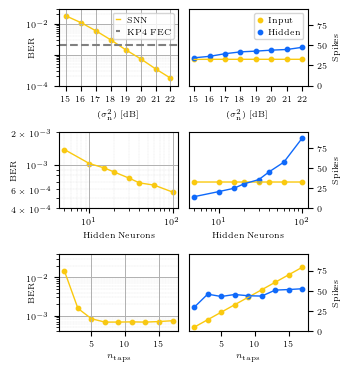

In [31]:
data = np.load("./test_bers.npy")
sizes_data = np.load("./hidden_size/test_bers.npy")
taps_data = np.load("./n_taps/test_bers.npy")
taps_data[:, 0] = [1, 3, 5, 7, 9, 11, 13, 15, 17]

import pickle
with open("../huawei/results/data/imdd/ecoc_jlt/ber_snr_references/1tap_linear.pkl", "rb") as file:
    data_linear_1tap = pickle.load(file)

with open("../huawei/results/data/imdd/ecoc_jlt/ber_snr_references/7tap_linear.pkl", "rb") as file:
    data_linear_7tap = np.array(pickle.load(file))
with open("../huawei/results/data/imdd/ecoc_jlt/ber_snr_references/7tap_snn_40_hidden.pkl", "rb") as file:
    data_snn_7tap = np.array(pickle.load(file))

with open("../huawei/results/data/imdd/ecoc_jlt/hw/snr_sweep_additive/n_hidden_40/n_taps_7/test_bers.pkl", "rb") as file:
    data_snn_bss_7tap = pickle.load(file)

print(data_snn_bss_7tap)


for s in sizes_data:
    print(s[0], s[0]*70 + s[0]*4, s[1], s[3]+s[4])

params = {'text.usetex' : True,
          'font.size' : 6,
          'font.family': "Times New Roman"
          }
plt.rcParams.update(params)

color = ["#FAC90F", "#FA8D0F", "#0F69FA", "#7A6F45"]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(3.5, 3.7))
axs[0, 0].set_ylabel("BER")
axs[0, 0].set_yscale("log")
axs[0, 0].set_ylim(1e-4, 3e-2)
axs[0, 0].set_xlim(14.5, 22.5)
axs[0, 0].grid(which="minor", lw=0.2, ls=":")
axs[0, 0].grid(which="major", lw=0.7)
axs[0, 0].set_xticks(data[:, 0])
axs[0, 0].plot(data[:, 0], data[:, 1], lw=1, color=color[0], label=r"SNN")
# axs[0, 0].plot(-data_linear_7tap[1:, 0], data_linear_7tap[1:, 1], lw=1, color=color[1], label=r"LLMSE \cite{arnold2023spiking}")
#axs[0, 0].plot(data_snn_bss_7tap["snrs"], data_snn_bss_7tap["bers"], lw=1, color=color[2], label=r"SNN, BSS-2 \cite{arnold2023spiking}")
#axs[0, 0].scatter(-data_linear_7tap[1:, 0], data_linear_7tap[1:, 1], s=10, color=color[1])
#axs[0, 0].scatter(data_snn_bss_7tap["snrs"], data_snn_bss_7tap["bers"], s=10, color=color[2])
axs[0, 0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs[0, 0].hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC")
axs[0, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[0, 0].set_xticks(data[:, 0])
axs[0, 0].set_yticks([1e-4, 1e-3, 1e-2])
axs[0, 0].set_yticklabels([r"$10^{-4}$", r"", r"$10^{-2}$"])
axs[0, 0].legend(fontsize=6, handlelength=0.5)
axs[0, 0].set_xlabel("$(\sigma^2_\mathrm{n})$ [dB]")


axs[1, 0].set_xticks(sizes_data[:, 0])
axs[1, 0].set_yscale("log")
axs[1, 0].set_xscale("log")
axs[1, 0].grid(which="minor", lw=0.2, ls=":")
axs[1, 0].grid(which="major", lw=0.7)
axs[1, 0].plot(sizes_data[:, 0], sizes_data[:, 1], lw=1, color=color[0])
axs[1, 0].scatter(sizes_data[:, 0], sizes_data[:, 1], color=color[0], s=10)
axs[1, 0].set_xticks([10, 100])
axs[1, 0].set_ylabel("BER")
axs[1, 0].yaxis.set_label_coords(-0.35, 0.5)
axs[1, 0].set_xlabel("Hidden Neurons")
axs[1, 0].set_ylim(4e-4, 2e-3)
#axs[1, 0].set_yticks([1e-3, 6e-4, 1e-3])
#axs[1, 0].set_yticklabels([r"$10^{-3}$", "", r"$10^{-3}$"])

axs[0, 1].set_xticks(data[:, 0])
axs[0, 1].set_ylim(0, 95)
axs[0, 1].plot(data[:, 0], data[:, 3], lw=1, color=color[0])
axs[0, 1].scatter(data[:, 0], data[:, 3], color=color[0], s=10, label="Input")
axs[0, 1].plot(data[:, 0], data[:, 4], lw=1, color=color[2])
axs[0, 1].scatter(data[:, 0], data[:, 4], color=color[2], s=10, label="Hidden")
axs[0, 1].set_xlabel("$(\sigma^2_\mathrm{n})$ [dB]")
axs[0, 1].legend(fontsize=6, handlelength=0.5)
axs[0, 1].set_ylabel("Spikes")
axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position("right")

axs[1, 1].set_ylim(0, 95)
axs[1, 1].set_xscale("log")
axs[1, 1].set_xlabel("Hidden Neurons")
axs[1, 1].set_xticks([10, 100])
axs[1, 1].plot(sizes_data[:, 0], sizes_data[:, 3], lw=1, color=color[0])
axs[1, 1].scatter(sizes_data[:, 0], sizes_data[:, 3], color=color[0], s=10, label="Input")
axs[1, 1].plot(sizes_data[:, 0], sizes_data[:, 4], lw=1, color=color[2])
axs[1, 1].scatter(sizes_data[:, 0], sizes_data[:, 4], color=color[2], s=10, label="Hidden")
axs[1, 1].yaxis.tick_right()
axs[1, 1].set_ylabel("Spikes")
axs[1, 1].yaxis.tick_right()
axs[1, 1].yaxis.set_label_position("right")


axs[2, 0].set_ylabel("BER")
axs[2, 0].set_yticks([1e-3, 5e-4])
axs[2, 0].set_xlabel("$n_\mathrm{taps}$")
axs[2, 0].set_ylim(4e-4, 4e-2)
axs[2, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[2, 0].set_xticks(sizes_data[:, 0])
axs[2, 0].set_yscale("log")
axs[2, 0].grid(which="minor", lw=0.2, ls=":")
axs[2, 0].grid(which="major", lw=0.7)
axs[2, 0].plot(taps_data[:, 0], taps_data[:, 1], lw=1, color=color[0])
axs[2, 0].scatter(taps_data[:, 0], taps_data[:, 1], color=color[0], s=10)
# axs[2, 0].yaxis.tick_right()


axs[2, 1].set_ylim(0, 95)
# axs[1, 1].grid(which="major", lw=0.7)
axs[2, 1].set_xlabel("$n_\mathrm{taps}$")
axs[2, 1].plot(taps_data[:, 0], taps_data[:, 3], lw=1, color=color[0])
axs[2, 1].scatter(taps_data[:, 0], taps_data[:, 3], color=color[0], s=10, label="Input")
axs[2, 1].plot(taps_data[:, 0], taps_data[:, 4], lw=1, color=color[2])
axs[2, 1].scatter(taps_data[:, 0], taps_data[:, 4], color=color[2], s=10, label="Hidden")
axs[2, 1].yaxis.tick_right()
axs[2, 1].set_ylabel("Spikes")
axs[2, 1].yaxis.set_label_position("right")

plt.tight_layout()
plt.savefig("./snr_task1.pgf")

Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Times New Roman
Ignoring unknown font: Ti

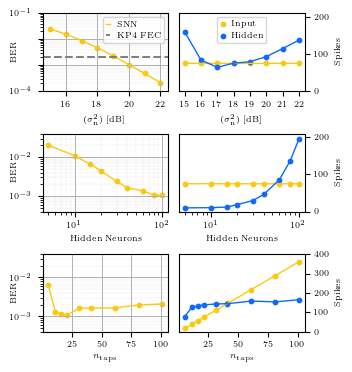

In [33]:
HIDDEN_SIZE = np.array( [5, 10, 15, 20, 30, 40, 60, 80, 100] )

BER = np.array( [0.02029,    0.01083,    0.00659687, 0.00441304, 0.00238929, 0.00162823, 0.00136419, 0.00105526, 0.00104896])
SR  = np.array([0.19972841, 0.10485899, 0.08031026, 0.09436933, 0.0990749,  0.11633541, 0.143151,   0.17173932, 0.19506817])
INSR = np.array([74.97167206, 75.02187347, 74.83611298, 74.88399506, 74.81110382, 74.93332672, 74.77696991, 74.90777588, 74.84936523])

SNR     = np.arange(15,24,1); #dB
SNR_BER = np.array([2.4767e-02, 1.5545e-02, 8.8205e-03, 4.6700e-03, 2.2860e-03, 1.0485e-03, 4.8150e-04, 2.1200e-04, 8.9000e-05])
SNR_SR  = np.array([0.17432287, 0.17357037, 0.17297274, 0.1725243,  0.17190584, 0.17170994, 0.17124321, 0.17094357, 0.1708009 ])
SNR_INSR = np.array([75.18222656, 74.99734863, 74.99654785, 74.95572754, 74.89522461, 74.83442383, 74.81555664, 74.81054688, 74.7313916 ])

EQ_TAP_CNT = np.array( [5, 11, 16, 21, 31, 41, 61, 81, 101] )
CNT_BER  = np.array([0.00645937, 0.00130974, 0.0011686,  0.00108967, 0.00162742, 0.00164426, 0.00165984, 0.00196442, 0.00209896] )
CNT_SR   = np.array( [0.09817875, 0.15845503, 0.16788274, 0.17312671, 0.17978497, 0.18138498, 0.19839855, 0.19297129, 0.20686917])
CNT_INSR = np.array([ 17.82550049, 39.20180893, 57.03392792, 74.87062073, 110.50068665, 146.20606995, 217.22317505, 288.75585938, 360.18182373])


params = {'text.usetex' : True,
          'font.size' : 6,
          'font.family': "Times New Roman"
          }
plt.rcParams.update(params)

color = ["#FAC90F", "#FA8D0F", "#0F69FA", "#7A6F45"]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(3.5, 3.7))
# axs[0, 0].set_ylabel("BER")
# axs[0, 0].set_yscale("log")
# axs[0, 0].set_ylim(1e-4, 3e-2)
# axs[0, 0].set_xlim(14.5, 22.5)
# axs[0, 0].grid(which="minor", lw=0.2, ls=":")
# axs[0, 0].grid(which="major", lw=0.7)
# axs[0, 0].set_xticks(data[:, 0])
# axs[0, 0].plot(SNR[:-1], SNR_BER[:-1], lw=1, color=color[0], label=r"SNN")
# # axs[0, 0].plot(-data_linear_7tap[1:, 0], data_linear_7tap[1:, 1], lw=1, color=color[1], label=r"LLMSE \cite{arnold2023spiking}")
# #axs[0, 0].plot(data_snn_bss_7tap["snrs"], data_snn_bss_7tap["bers"], lw=1, color=color[2], label=r"SNN, BSS-2 \cite{arnold2023spiking}")
# #axs[0, 0].scatter(-data_linear_7tap[1:, 0], data_linear_7tap[1:, 1], s=10, color=color[1])
# #axs[0, 0].scatter(data_snn_bss_7tap["snrs"], data_snn_bss_7tap["bers"], s=10, color=color[2])
# axs[0, 0].scatter(SNR[:-1], SNR_BER[:-1], color=color[0], s=10)
# axs[0, 0].hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC")
# axs[0, 0].yaxis.set_label_coords(-0.1, 0.6)
# axs[0, 0].set_xticklabels([])
# axs[0, 0].legend(fontsize=6, handlelength=0.5)
# 
# axs[1, 0].set_ylim(4e-4, 4e-2)
# axs[1, 0].set_xticks(sizes_data[:, 0])
# axs[1, 0].set_yscale("log")
# axs[1, 0].set_xscale("log")
# axs[1, 0].grid(which="minor", lw=0.2, ls=":")
# axs[1, 0].grid(which="major", lw=0.7)
# axs[1, 0].plot(HIDDEN_SIZE, BER, lw=1, color=color[0])
# axs[1, 0].scatter(HIDDEN_SIZE, BER, color=color[0], s=10)
# axs[1, 0].yaxis.tick_right()
# axs[1, 0].set_yticks([1e-2, 1e-3])
# axs[1, 0].set_xticks([])


axs[0, 0].set_ylabel("BER")
axs[0, 0].set_yscale("log")
axs[0, 0].set_ylim(1e-4, 1e-1)
axs[0, 0].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[0, 0].set_xlim(14.5, 22.5)
axs[0, 0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
axs[0, 0].set_yticklabels([r"$10^{-4}$", "", "", r"$10^{-1}$"])
axs[0, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[0, 0].grid(which="minor", lw=0.2, ls=":")
axs[0, 0].grid(which="major", lw=0.7)
axs[0, 0].plot(SNR[:-1], SNR_BER[:-1], lw=1, color=color[0], label=r"SNN")
axs[0, 0].scatter(SNR[:-1], SNR_BER[:-1], color=color[0], s=10)
axs[0, 0].hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC")
axs[0, 0].legend(fontsize=6, handlelength=0.5)


axs[0, 1].set_xticks(data[:, 0])
axs[0, 1].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[0, 1].set_ylabel("Spikes")
axs[0, 1].set_ylim(0, 210)
axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position("right")
axs[0, 1].plot(SNR[:-1], INSR[:-1], lw=1, color=color[0])
axs[0, 1].scatter(SNR[:-1], INSR[:-1], color=color[0], s=10, label="Input")
axs[0, 1].plot(SNR[:-1], SR[:-1]*10*80, lw=1, color=color[2])
axs[0, 1].scatter(SNR[:-1], SR[:-1]*10*80, color=color[2], s=10, label="Hidden")
axs[0, 1].legend(fontsize=6, handlelength=0.5)


axs[1, 0].set_xlabel("Hidden Neurons")
axs[1, 0].set_xticks([10, 100])
axs[1, 0].set_xticks(sizes_data[:, 0])
axs[1, 0].set_xscale("log")
axs[1, 0].set_ylabel("BER")
axs[1, 0].set_ylim(4e-4, 4e-2)
axs[1, 0].set_yscale("log")
axs[1, 0].set_yticks([1e-3, 1e-2])
#axs[1, 0].set_yticklabels([r"$10^{-3}$", "", r"$10^{-2}$"])
axs[1, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[1, 0].grid(which="minor", lw=0.2, ls=":")
axs[1, 0].grid(which="major", lw=0.7)
axs[1, 0].plot(HIDDEN_SIZE, BER, lw=1, color=color[0])
axs[1, 0].scatter(HIDDEN_SIZE, BER, color=color[0], s=10)


axs[1, 1].set_xscale("log")
axs[1, 1].set_xticks([10, 100])
axs[1, 1].set_xlabel("Hidden Neurons")
axs[1, 1].set_ylabel("Spikes")
axs[1, 1].set_ylim(0, 210)
axs[1, 1].yaxis.tick_right()
axs[1, 1].yaxis.set_label_position("right")
axs[1, 1].plot(HIDDEN_SIZE, INSR, lw=1, color=color[0])
axs[1, 1].scatter(HIDDEN_SIZE, INSR, color=color[0], s=10, label="Input")
axs[1, 1].plot(HIDDEN_SIZE, SR*HIDDEN_SIZE*10, lw=1, color=color[2])
axs[1, 1].scatter(HIDDEN_SIZE, SR*HIDDEN_SIZE*10, color=color[2], s=10, label="Hidden")


axs[2, 0].set_ylabel("BER")
#axs[2, 0].set_yticks([1e-3, 5e-4])
axs[2, 0].set_xlabel("$n_\mathrm{taps}$")
axs[2, 0].set_ylim(4e-4, 4e-2)
#axs[2, 0].set_xticks(sizes_data[:, 0])
axs[2, 0].set_yscale("log")
axs[2, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[2, 0].grid(which="minor", lw=0.2, ls=":")
axs[2, 0].grid(which="major", lw=0.7)
axs[2, 0].plot(EQ_TAP_CNT, CNT_BER, lw=1, color=color[0])
axs[2, 0].scatter(EQ_TAP_CNT, CNT_BER, color=color[0], s=10)


axs[2, 1].set_ylabel("Spikes")
axs[2, 1].yaxis.set_label_position("right")
axs[2, 1].yaxis.tick_right()
axs[2, 1].set_ylim(0, 400)
axs[2, 1].set_xlabel("$n_\mathrm{taps}$")
axs[2, 1].plot(EQ_TAP_CNT, CNT_INSR, lw=1, color=color[0])
axs[2, 1].scatter(EQ_TAP_CNT, CNT_INSR, color=color[0], s=10, label="Input")
axs[2, 1].plot(EQ_TAP_CNT, CNT_SR*80*10, lw=1, color=color[2])
axs[2, 1].scatter(EQ_TAP_CNT, CNT_SR*80*10, color=color[2], s=10, label="Hidden")


plt.tight_layout()
plt.savefig("./snr_task2.pgf")